In [69]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Ff
import torch.optim as optim 
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [70]:
# Hyperparameters
num_epochs = 250
batch_size = 64
learning_rate = 0.001

MODEL_STORE_PATH = './model'

In [71]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((28, 28)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [72]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [73]:
# Helper function to un-normalize and display an image
def imshow(img):
    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image


In [74]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

noise_factor = 0.1
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
images = images.numpy() 
noisy_imgs=noisy_imgs.numpy()
def displayImages(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display noisy images
        ax = plt.subplot(2, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "Original Images", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.5, "Noisy Images", ha="center", va="top", fontsize=14, color="b")
    plt.subplots_adjust(hspace = 0.3 )
        
    plt.show()


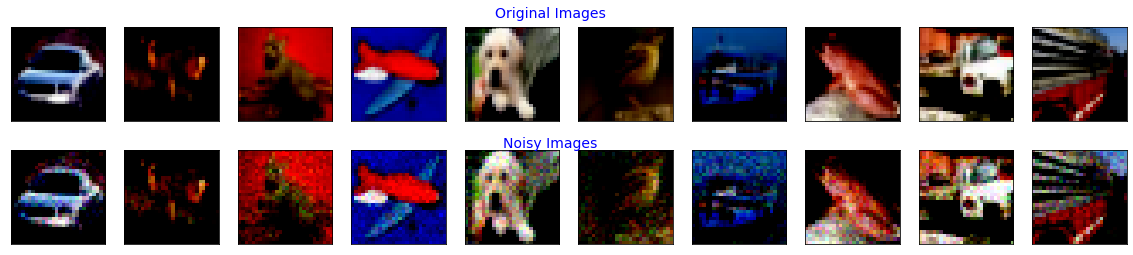

In [75]:
displayImages(images,noisy_imgs)

In [76]:
# For finding output dimensions from Convolution and Transposed Convolutions

# Output dimensions from Convolution
def in_dim(inp, F, P, S):
    out = int((inp - F + 2*P)/S + 1)
    return out

#Output dimension from Transposed convolution
def out_dim(inp, F, P, S, out_pad):
    out = (inp - 1)*S + F - 2*P + out_pad
    return out

In [77]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=1, padding=2), #28 -> 28
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=2), #28 -> 14
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=1, padding=2), #14 -> 14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 5, stride=1, padding=0), #7 -> 7
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Deconvolutional layers
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 5, stride=1, padding = 0), #7 -> 14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 5, stride=1, padding = 2), #14 -> 14
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding = 2, output_padding=1), #14 -> 28
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 5, stride=1, padding = 2), #28 -> 28
            nn.BatchNorm2d(3),
        )
        
    def forward(self, x):
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [78]:
# Emptying CUDA Cache
torch.cuda.empty_cache()

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [79]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Set the random seed for reproducible results
torch.manual_seed(0)

encoder = Encoder()
decoder = Decoder()
parameters = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

# Initializing the optimizer
optim = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=1e-05)

In [80]:
# Getting the layers as a list
encoder_children =  list(encoder.children())
decoder_children = list(decoder.children())

In [81]:
encoder_children

[Sequential(
   (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace=True)
   (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace=True)
   (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
   (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace=True)
 )]

In [82]:
decoder_children

[Sequential(
   (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace=True)
   (6): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
   (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace=True)
   (9): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 )]

In [83]:
# Noise addition function
def add_noise(inputs,noise_factor=0.1):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [84]:
from random import randint
idx = randint(1, batch_size)

In [85]:
def image_score(reconstructed, input):

    reconstructed = reconstructed.detach().cpu()
    input = input.detach().cpu()

    PWD = nn.PairwiseDistance(p=2, eps = 1e-6)
    score = torch.mean(PWD(reconstructed, input))

    return score

In [86]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i, (image_batch, _) in enumerate(dataloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if i%100 == 0:
            print('\t Step [{}/{}] Train loss : {:.4f}'. format(i+1, len(dataloader),loss.data))
            train_loss.append(loss.detach().cpu().numpy())

    cosine_train = image_score(decoded_data[0], image_batch[0])

    return np.mean(train_loss), cosine_train

In [87]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original signal to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        cosine_val = image_score(decoded_data, image_batch)
    return cosine_val

In [88]:
def plot_ae_outputs_den(encoder,decoder,noise_factor):
  
    plt.figure(figsize=(15, 20))  

    ax = plt.subplot(5,1,1)
    idx = randint(0, len(test_dataset))
    image = test_dataset[idx][0].unsqueeze(0)
    image_noisy = add_noise(image, noise_factor)     
    image_noisy = image_noisy.to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        reconstructed_image = decoder(encoder(image_noisy))

    image = np.reshape(image.cpu().squeeze().numpy(), (3,28,28))
    imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    ax.set_title('Original Image')

    ax = plt.subplot(5, 1, 2)
    image_noisy = np.reshape(image_noisy.cpu().squeeze().numpy(), (3,28,28))
    imshow(image_noisy)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    ax.set_title('Noisy Image')

    ax = plt.subplot(5, 1, 3)
    reconstructed_image = np.reshape(reconstructed_image.cpu().squeeze().numpy(), (3,28,28)) 
    imshow(reconstructed_image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    ax.set_title('Reconstructed Image')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

In [ ]:
### Training cycle
noise_factor = 0.1
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss, score_train=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn,
        optimizer=optim,
        noise_factor=noise_factor)

    ### Validation  (use the testing function)
    score_val = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_loader, 
        loss_fn=loss_fn,
        noise_factor=noise_factor)
    
    # Print Validation loss
    history_da['train_loss'].append(train_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss))
    print('\nTraining Score = {} \t Validation Score = {}\n'.format(score_train, score_val))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

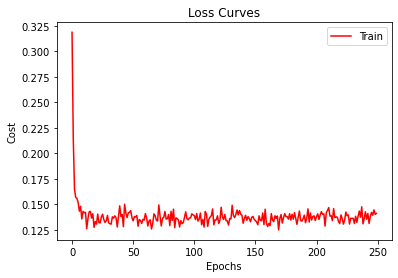

In [90]:
# Plotting Loss Curves

plt.plot(history_da['train_loss'], color = 'r', label = 'Train')
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [91]:
# Saving the model
torch.save(encoder, MODEL_STORE_PATH)
torch.save(decoder, MODEL_STORE_PATH)

In [ ]:
# Loading the model
encoder = torch.load(MODEL_STORE_PATH)
decoder = torch.load(MODEL_STORE_PATH)
encoder.eval()
decoder.eval()